General purpose imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, patches

import hystorian as hy
from hystorian.processing import twodim
import h5py

import os
from glob import glob

from IPython.display import clear_output

Next, we load all the data in `raw_data_path` into the `.hdf5` format and store it in `data_path`. We make one `.hdf5` file per sample, by assuming the raw data filenames start with the sample name followed by an underscore.

In [2]:
allowed_extensions = set(('.ibw', '.sxm'))
raw_data_path = os.path.join('data', 'to_convert')
data_path = 'data'
skipped_list = []
already_converted = []
to_convert = {}

for fn in glob(os.path.join(raw_data_path, '**'), recursive=True):
    
    #skip anything that doesn't have an allowed extension
    if os.path.splitext(fn)[1] not in allowed_extensions:
        skipped_list.append(fn)
        continue
    
    measurement_name = os.path.splitext(os.path.basename(fn))[0]
    sample_name = measurement_name.split('_')[0]
    combined_name = os.path.join(data_path, sample_name)
    
    #check if the sample file exists 
    if os.path.isfile(combined_name+'.hdf5'):
        with h5py.File(combined_name+'.hdf5', 'r') as f:
            #check if the measurement is already there
            if f'datasets/{measurement_name}' in f:
                already_converted.append(measurement_name)
                continue
    
    #Since the measurement is not there, add it to the list to convert
    to_convert.setdefault(combined_name, []).append(fn.replace('\\', '/'))    
    
for combined_name, filelist in to_convert.items():
    hy.io.read_file.merge_hdf5(filelist, combined_name)

for combined_name in to_convert:
    sample_name = os.path.basename(combined_name)
    with h5py.File(combined_name+'.hdf5', 'r+') as f:
        #check if sample thickness is given, ask for it if not
        if f['datasets'].attrs.get('Thickness_uc') is None:
            try:
                f['datasets'].attrs.create('Thickness_uc',
                                            int(input(f'What is the thickness of {sample_name} in uc?')))
            except ValueError:
                pass
                  
    
print('The following measurements were converted previously and have been ignored:')
for mn in already_converted: print(mn)
print('\n')

print('The following files were skipped:')
for fn in skipped_list: print(fn)
print('If any of these files should have been included, check the allowed extensions.')

The following measurements were converted previously and have been ignored:
m21003b_topo_MC_009
m21004DSOJ4_topo_MC_005
m21004DSOJ4_topo_MC_008
m21005b_topo_MC_006
m21005b_topo_MC_009
m21006DSOI2_topo_MC_005
m21007b_topo_MC_003
m20036_topo_MC_006
m20036_topo_MC_007
m20036_topo_MC_008
m20037_topo_MC_003
m20037_topo_MC_004
m20038_topo_MC_006
m20038_topo_MC_007
m20038_topo_MC_010
m20039_topo_MC_010
m20039_topo_MC_011
m20041_topo_MC_006
m20041_topo_MC_007
m21003DSOJ2_topo_MC_006
m21003DSOJ2_topo_MC_009
m21005DSOF2_topo_MC_005
m21005DSOF2_topo_MC_008
m21007DSOC3_topo_MC_005


The following files were skipped:
data\to_convert\
data\to_convert\old
If any of these files should have been included, check the allowed extensions.


Next, we test the autocorrelation kit on dummy data.

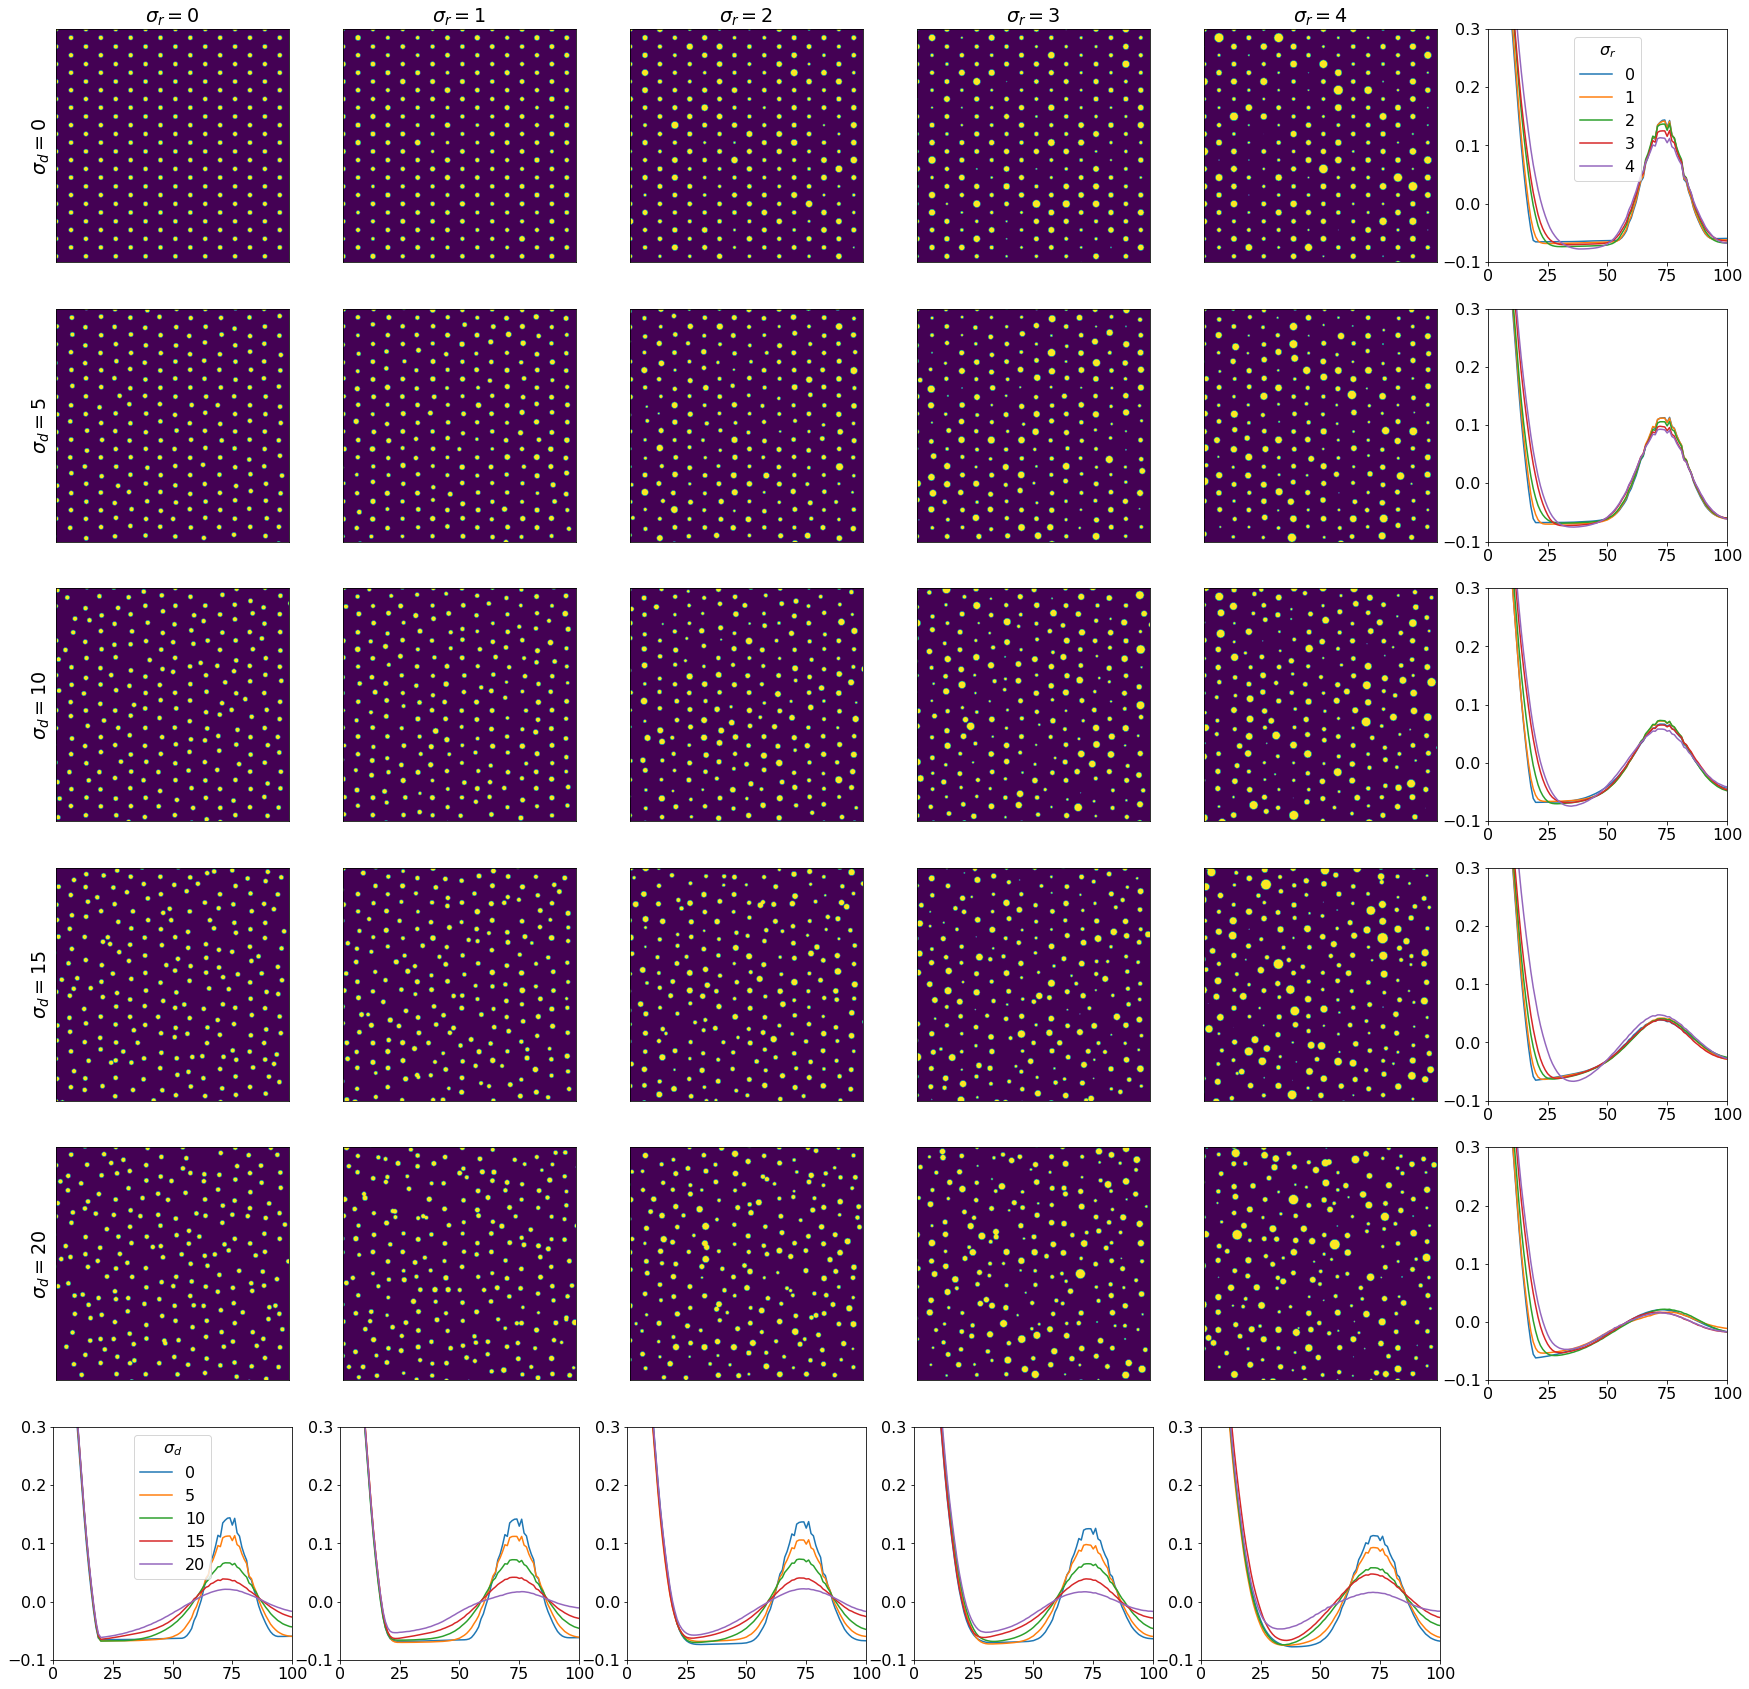

In [3]:
plt.rcParams.update({'font.size': 16,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                    })

lattsize = 1000
r = 10
dr = 0
d = 75
dd = 0
dds = [0, 5, 10, 15, 20]
drs = [0, 1, 2, 3, 4]

np.random.seed(0)

fig, axs_lines = plt.subplots(len(dds)+1, len(drs)+1, figsize=(5 * (len(drs)+1), 5 * (len(dds)+1)))
xlims = (0.0, 100)
ylims = (-0.1, 0.3)


for axs, dd in zip(axs_lines[:-1], dds):
    for j, (ax, dr) in enumerate(zip(axs[:-1], drs)):
        
        lattice = twodim.generate_triangular_lattice(lattsize, r, dr, d, dd)

        ax.imshow(lattice)
        ax.set_xticks([])
        ax.set_yticks([])

        ac = twodim.autocorrelate(lattice, mode = 'same')#padding='wrap')     

        x, y = twodim.radial_average(ac)
                              
        axs[-1].plot(x, y)      
        #axs[-1].scatter(x[local_max_1D(y)], y[local_max_1D(y)])
        #axs[-1].scatter(x[local_max_1D(-y)], y[local_max_1D(-y)])
                              
        axs_lines[-1][j].plot(x, y)
        #axs_lines[-1][j].scatter(x[local_max_1D(y)], y[local_max_1D(y)])
        #axs_lines[-1][j].scatter(x[local_max_1D(-y)], y[local_max_1D(-y)])
    axs[-1].set_xlim(xlims)
    axs[-1].set_ylim(ylims)
                              
for ax in axs_lines[-1]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
#ax2.legend(variable)
#ax2.set_xlim(0.0, 75)

axs_lines[0][-1].legend(drs, title='$\sigma_r$')
axs_lines[-1][0].legend(dds, title='$\sigma_d$')

for ax, dr in zip(axs_lines[0][:-1], drs):
    ax.set_title('$\sigma_r = {}$'.format(dr))
    
for ax, dd in zip(axs_lines[:-1, 0], dds):
    ax.set_ylabel('$\sigma_d = {}$'.format(dd))

fig.delaxes(axs_lines[-1][-1])

(0.0, 100.0)

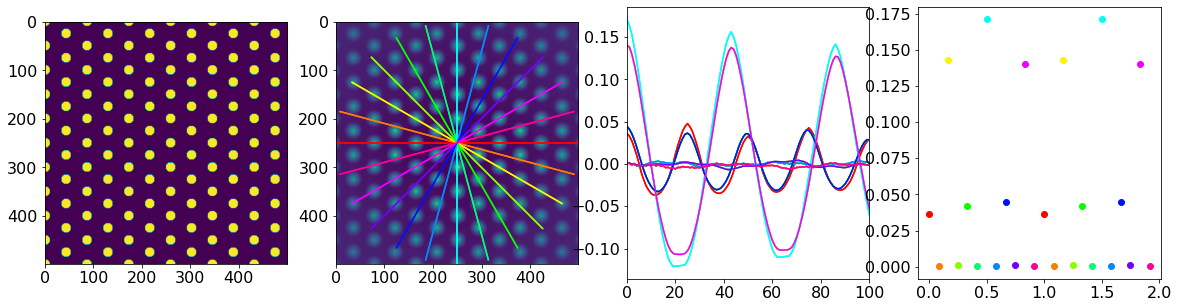

In [5]:
data = twodim.generate_triangular_lattice(lattsize=500)
#data = np.random.random((500, 500))
ac = twodim.autocorrelate(data, mode = 'same')
sx, sy = ac.shape

fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].imshow(data)
axs[1].imshow(ac)

for angle in np.arange(0, 2*np.pi, np.pi/12):
    color = cm.hsv(angle/np.pi%1)
    x, y = twodim.projected_average(ac, angle=angle)
    axs[2].plot(x, y, color=color, alpha=1)
    axs[1].plot(((sx-1)/2*(1-np.cos(angle)),(sx-1)/2*(1+np.cos(angle))),
                ((sy-1)/2*(1-np.sin(angle)),(sy-1)/2*(1+np.sin(angle))), color=color)
    axs[3].scatter(angle/np.pi, y[0], color=color)

axs[2].set_xlim(0,100)

In [30]:
for fn in glob('data/*'):
    print(fn.replace('\\', '/'))

data/Celine
data/LoopsCeline-color.png
data/m20036.hdf5
data/m20037.hdf5
data/m20038.hdf5
data/m20039.hdf5
data/m20041.hdf5
data/m21003b.hdf5
data/m21003DSOJ2.hdf5
data/m21004DSOJ4.hdf5
data/m21005b.hdf5
data/m21005b_topo_MC_006.sxm
data/m21005DSOF2.hdf5
data/m21006DSOI2.hdf5
data/m21007b.hdf5
data/m21007DSOC3.hdf5
data/test.txt
data/to_convert


In [39]:
with h5py.File('data/m20038.hdf5', 'r') as f:
    for key in f['datasets']: print(key)
    

m20038_topo_MC_006
m20038_topo_MC_007
m20038_topo_MC_010
